In [1]:
# load data
import pandas as pd
import openpyxl

# system tools
import os
import sys
sys.path.append("..") # set to "." in py script

# data munging tools
import pandas as pd

# Machine learning stuff
from sklearn.feature_extraction.text import CountVectorizer#, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics

# Visualisation (not nessecary?)
import matplotlib.pyplot as plt

# Shap values document classification
import shap
import tensorflow

/home/coder/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/coder/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_

In [2]:
# load sermon data
data = pd.read_csv("../../../768706/data/content.dat", index_col=0)

In [3]:
# load metadata
meta = pd.read_excel("../../../768706/metadata/Joined_Meta.xlsx")

Unknown extension is not supported and will be removed


In [4]:
# merge on document IDs
full_data = data.merge(meta, left_on="id", right_on="ID-dok")

__Simple classification with scikit-learn as in nb sesssion 5__

In [5]:
X = full_data["content"]
y = full_data["køn"]

labels = ["male", "female"]

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,           # texts for the model
                                                    y,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split
                                                    random_state=42) # random state for reproducibility

In [26]:
# create vectorizer object using a bag-of-words model
vectorizer = CountVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word (e.g. York) and 2 word (e.g. New York) units)
                             lowercase =  True,       # make everything lower case
                             max_df = 0.95,           # remove very common words
                             min_df = 0.05,           # remove very rare words
                             max_features = 100)      # keep only top 500 features (or 100?)

In [27]:
# fit vectorizer to training data
X_train_feats = vectorizer.fit_transform(X_train)

# transform test data
X_test_feats = vectorizer.transform(X_test)

# get feature names
feature_names = vectorizer.get_feature_names_out()

In [9]:
classifier = MLPClassifier(activation = "logistic", # maybe try relu
                           hidden_layer_sizes = (30, 10), # number of notes in hidden layers 
                           max_iter=1000, # maybe try less iterations
                           random_state = 42)

In [28]:
# fit data to the classifier
classifier.fit(X_train_feats, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(30, 10), max_iter=1000,
              random_state=42)

In [29]:
# Get predictions
y_pred = classifier.predict(X_test_feats)

In [30]:
# Print predictions
print(y_pred[:20])

[1 2 1 1 2 2 2 1 2 1 2 1 1 2 1 1 2 2 1 1]


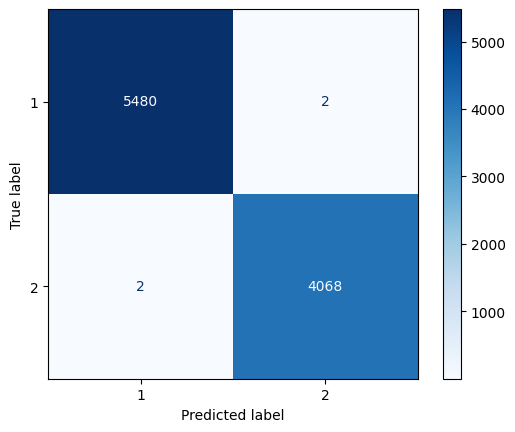

In [31]:
# Evaluation with confusion matrix 
metrics.ConfusionMatrixDisplay.from_estimator(classifier,           # the classifier name
                                            X_train_feats,          
                                            y_train,                # the training labels
                                            cmap=plt.cm.Blues,      # make the colours prettier
                                            labels=[1, 2])# the labels in your data arranged alphabetically

In [32]:
# 30, 10
# vec 95, 5
classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
print(classifier_metrics)

              precision    recall  f1-score   support

        male       0.71      0.70      0.71      1336
      female       0.63      0.64      0.63      1052

    accuracy                           0.68      2388
   macro avg       0.67      0.67      0.67      2388
weighted avg       0.68      0.68      0.68      2388



In [ ]:
# 30, 5
# vec 95, 5
#classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
#print(classifier_metrics)

In [ ]:
# 40, 10
# vec 95, 5
#classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
#print(classifier_metrics)

In [ ]:
# 40, 10
# vec 90, 10
#classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
#print(classifier_metrics)

In [ ]:
# 100, 25
# vec 95, 05
#classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
#print(classifier_metrics)

In [ ]:
# 50, 20
# vec 95, 05
#classifier_metrics = metrics.classification_report(y_test, y_pred, target_names=labels )
#print(classifier_metrics)

From now on I code with the model 30, 10 (0.95, 0.05)

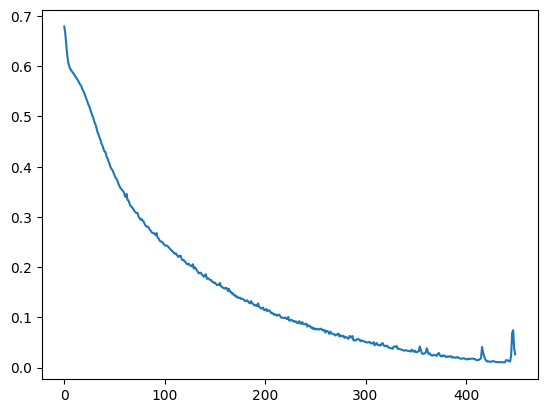

In [33]:
plt.plot(classifier.loss_curve_)
#the plot: we want a smooth and steep downward slope which ends at a plateau.
#the x-axis if the number of times the model runs through the steps

In [34]:
#Save classification report in "out"
folder_path = os.path.join("..", "out")
file_name = "classificationreport.txt"
file_path = os.path.join(folder_path, file_name)
with open(file_path, "w") as f: #"writing" classifier report and saving it
    f.write(classifier_metrics)

In [35]:
from joblib import dump, load
# save classifier
clf_outpath = os.path.join("..", "models", "sermon_gender_clf") # remove .. when .py script
dump(classifier, clf_outpath)
# save vectorizer
vec_outpath = os.path.join("..", "models", "sermon_vectorizer.joblib")
dump(vectorizer, vec_outpath)

['../models/sermon_vectorizer.joblib']

## Shap values document classification

To avoid our model to be a "black box" model (a model were you don't know what is going on).

"Shap value helps us quantify feature’s contribution towards a prediction. Shap value closer to zero means the feature contributes little to the prediction whereas shap value away from zero indicates the feature contributes more" (https://towardsdatascience.com/explaining-scikit-learn-models-with-shap-61daff21b12a).

100%|██████████| 100/100 [14:38<00:00,  8.79s/it]


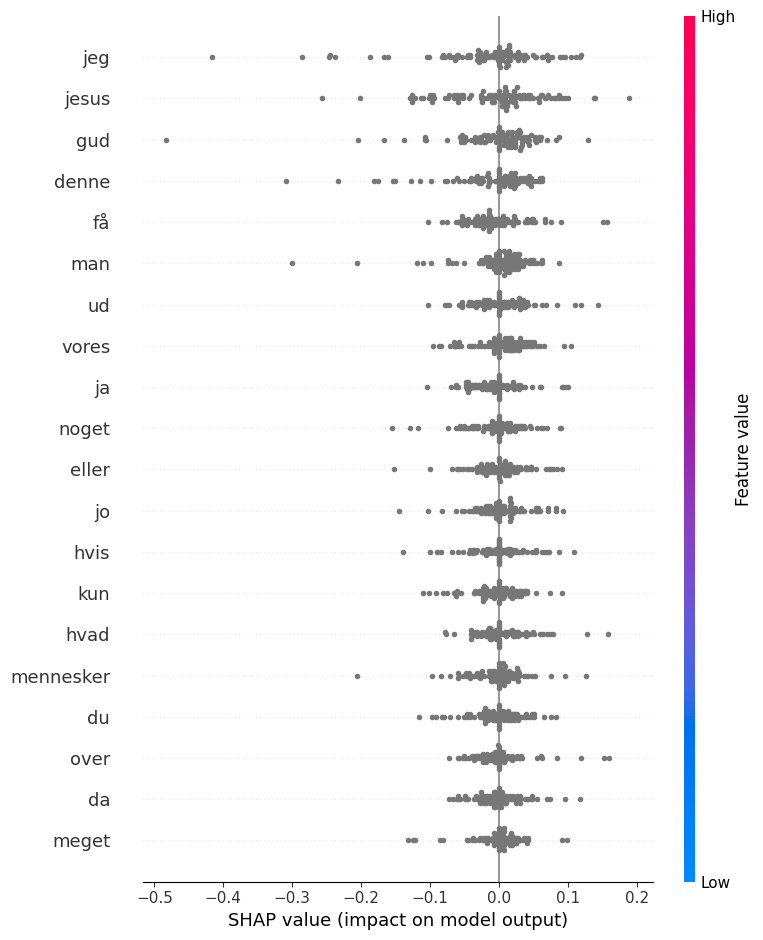

In [36]:
explainer = shap.KernelExplainer(classifier.predict, shap.sample(X_train_feats, 100)) # the number is the number of sermons that I am looking at. 
shap_values = explainer.shap_values(shap.sample(X_test_feats, 100))
#shap.summary_plot(shap_values, shap.sample(X_train_feats, 5), feature_names)
shap.summary_plot(shap_values, shap.sample(X_test_feats, 100), feature_names)

# Save shap plot
shap_plot_path = os.path.join("..", "out", "shap_plot.png")
plt.savefig(shap_plot_path)